To classify audio, you first need present it somehow to the classifier. You may notice everyone is talking about **spectrogram, FFT, STFT, MFCC**, but why don't we **just use audio?** What does it all stand for?

### **Here comes a little explanation!**

tip: most interesting things are marked as **QUESTION**

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

### Samples

We can load the first two samples we'll be working on

In [2]:
train_audio_path = '../input/train_curated/' 
# 8a8110c2 c2aff189 d7d25898 0a2895b8 6459fc05 54940c5c 024e0fbe c6f8f09e f46cc65b  
# 1acaf122 a0a85eae da3a5cd5 412c28dd 0f301184 2ce5262c
sample_rate, samples1 = wavfile.read(os.path.join(train_audio_path, '98b0df76.wav'))
sample_rate, samples2 = wavfile.read(os.path.join(train_audio_path, 'd7d25898.wav'))

How do they sound?

In [3]:
ipd.Audio(samples1, rate=sample_rate)

In [4]:
ipd.Audio(samples2, rate=sample_rate)

In [5]:
def plot_raw_wave(samples):
    plt.figure(figsize=(14, 3))
    plt.title('Raw wave')
    plt.ylabel('Amplitude')
    # ax1.plot(np.linspace(0, sample_rate/len(samples1), sample_rate), samples1)
    plt.plot(samples)
    plt.show()


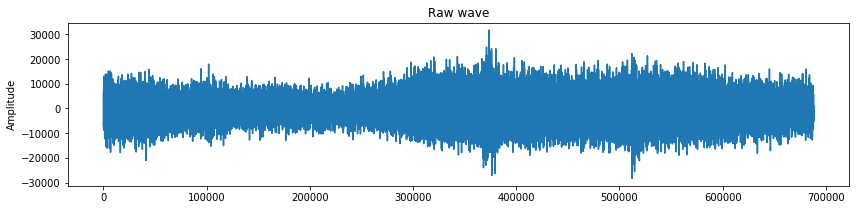

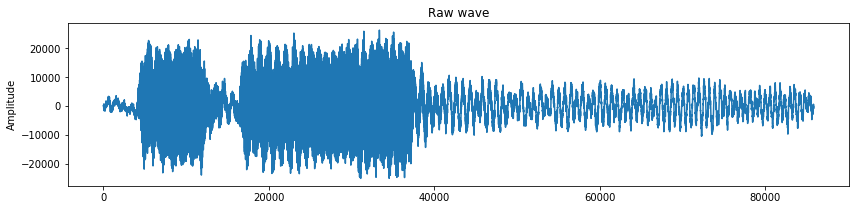

In [6]:
plot_raw_wave(samples1)
plot_raw_wave(samples2)

You can easily SEE 2 beeps in the second wave, and constant noise in first one. The problem is that it is impossible to understand or interpret the pitch of a sound watching physical illustration as above.

The first thing we need to understand: the sample rate. yYou can read about it [here](https://en.wikipedia.org/wiki/Sampling_(signal_processing))

## Sampling rate: Intuition

So wait, does it mean one second of a recording has 44100 samples ('features'), so the longest recordings will have _30*44100 = 1323000_ elements? Yes. That's one of the reasons why we need some different representation of an audio signal.


But hey, if this fluctuations are what directly come into the human ear, shouldn't we use it directly? Not really. Human hearing is a tough topic, not well understood, but we can assume that our brain hears rather something like frequencies ( [Reference](https://en.wikipedia.org/wiki/Place_theory_(hearing)) )


## What is frequency?
An explanation [here](http://www.indiana.edu/~emusic/etext/acoustics/chapter1_frequency.shtml) and a nice tutorial about calculating the frequencies here: [link](https://www.youtube.com/watch?v=r18Gi8lSkfM). The mathematical tool for that is Fast Fourier Transform (FFT)

Briefly: 
- low sounds are long waves
- higher sounds are shorter waves

**To calculate frequencies, we calculate the amount of long waves and the amount of short waves ** 

We analyze our two examples: the one with "low" sounds, and one with high pitches.

In [7]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

def plot_custom_fft(samples, sample_rate):
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

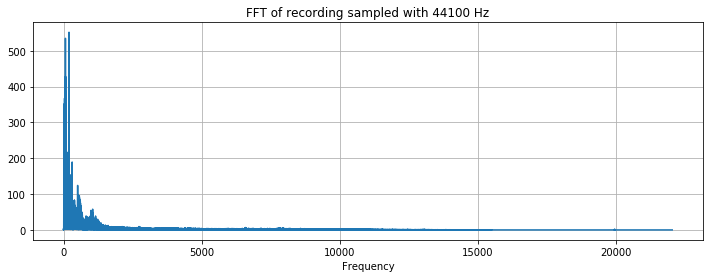

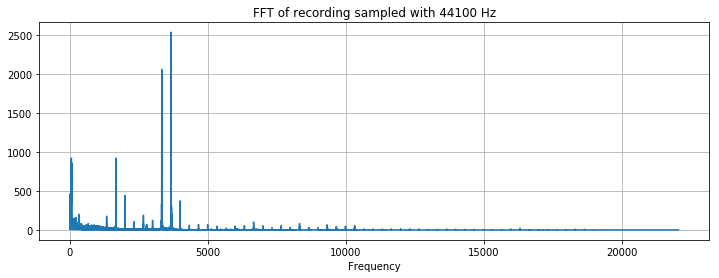

In [8]:
plot_custom_fft(samples1, sample_rate)
plot_custom_fft(samples2, sample_rate)

Great to see that FFT really shows bigger amplitude in low freqs in machine noise and big amplitude in high freqs for beeps.

**FFT is not enough**

We can indeed calculate all the frequencies in audio. But sound differs in time, so maybe we should calculate the frequencies for a small part of a signal, to show the time dependencies?

We can easily do that. We call the result **spectrogram**

How to create spectrogram in 3 steps:
1. Cut the signal by overlapping windows 20 ms windows
2. Find short and long waves (frequencies in this window) using FFT
3. Concatenate the calculated frequencies. 


Let's implement it:

In [9]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def plot_log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    
    fig = plt.figure(figsize=(14, 3))
    freqs, times, spectrogram = log_specgram(audio, sample_rate)
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.title('Spectrogram')
    plt.ylabel('Freqs in Hz')
    plt.xlabel('Seconds')
    plt.show()

And now we visualize our two examples using the spectrogram

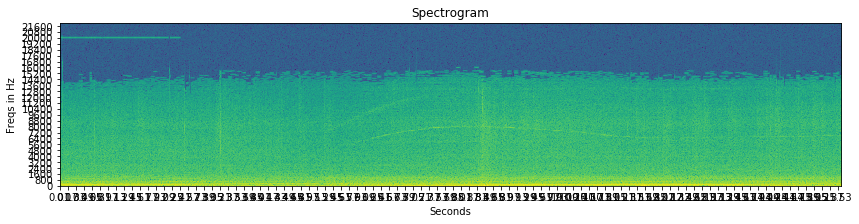

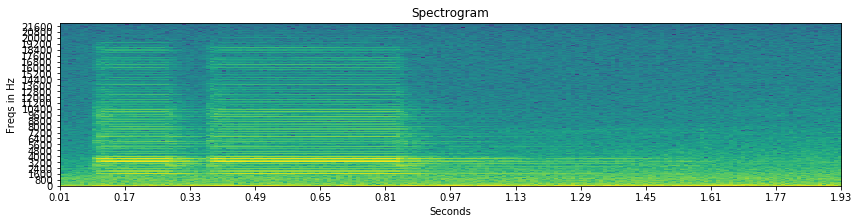

In [10]:
plot_log_specgram(samples1, sample_rate)
plot_log_specgram(samples2, sample_rate)

### Important:

This is really a representation that **reflects and takes into account the audible properties of a signal**. Do you agree?

## **Nyquist theorem**

Interesting property: according to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate) we can hear only frequencies twice lower than the sampling rate.

I not going to present this fact here, but what I want to say is:

#### ** QUESTION!!! **

**Do we really need 44100 samples per sec (frequencies between 0 and 22.1k?)**

Even your laptop speakers can't pass these freqs, but you can crearly classify the stuff well, so maybe downsampling is a good idea?

#### ** QUESTION!!! **

**Why we split signal in 20 ms parts?**

20 ms is a mean time of the shortest speech p**art, phonem. But wait, it's not a speech recognition competition, so maybe we should use longer windows? I think we should

## MFCC
<a id="mfcc"></a> 

If you want to get to know some details about *MFCC* take a look at this great tutorial. [MFCC explained](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) You can see, that it is well prepared to imitate human hearing properties.

You can calculate *Mel power spectrogram* and *MFCC* using, for example, *librosa* python package.


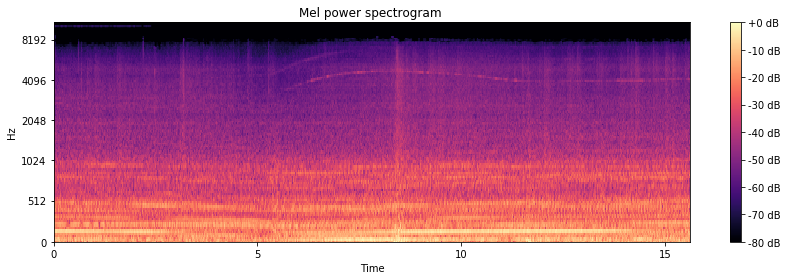

In [11]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples1.astype(float), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



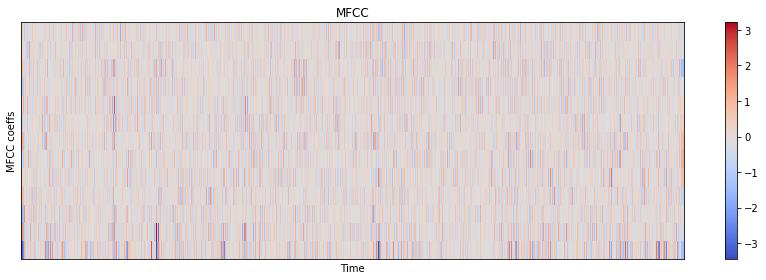

In [12]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

Explanation: 

Human hearing is complex - we hear some frequencies more than other - and we can imitate it using the above techniques. 


#### ** QUESTION!!! **

**Should we use MFCC? **

We evolved to here the environment and the speech, so I think we may not have the best detectors for some artificial signals, but I feel good at the classification with my natural filters, so I would USE MFCC.

And MFCC decorrelates the features! It's a nice property because the features are more distinct and tell more clear things.

## Bonus - spectrogram in 3d

In [13]:
freqs, times, spectrogram = log_specgram(samples2, sample_rate)
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
#     scene = dict(
#     yaxis = dict(title='Frequencies', range=freqs),
#     xaxis = dict(title='Time', range=times),
#     zaxis = dict(title='Log amplitude'),
#     ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

---

**If you like my work please upvote.**

Leave a feedback that will let me improve! 